## Import libraries

In [111]:
import glob
import numpy as np
from nilearn.image import load_img
from nilearn.image import new_img_like
from nilearn.image import index_img
from nilearn.image import concat_imgs
from nilearn.image import mean_img
from brainiak.searchlight.searchlight import Searchlight
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from scipy.stats import ttest_1samp as ttest

from nilearn import datasets
from nilearn.image import load_img
from nilearn.image import index_img
from nilearn import surface
from nilearn import plotting
%matplotlib inline

def _r2z(r):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))

## Collect permutations

In [112]:
# ref_img = load_img('/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/sherlock_movie_s1_10000.nii.gz')
# ref_img = index_img(ref_img, 0)

# for perm in range(100):
#     print('perm #%s' % str(perm))
#     imgs_recall = []
#     for sub in range(1, 18):
#         fpath = glob.glob('/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/searchlight_movie/perms/s%s_perm%s_*' % (str(sub), str(perm)))
#         sub_data = np.load(fpath[0])
#         img = new_img_like(ref_img, sub_data.astype(np.float))
#         imgs_recall.append(img)
#     imgs_recall = concat_imgs(imgs_recall)
#     x, y, z, t = imgs_recall.shape
#     statmap = ttest(np.moveaxis(imgs_recall.get_data(), -1, 0), 0).statistic
#     img = new_img_like(ref_img, statmap.astype(np.float))
#     img.to_filename('/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/searchlight_movie/perms/' + 'perm%s' % str(perm))

## Load in permutations and sort them

In [113]:
fpath = '/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/searchlight_movie/perms/'
perms = [load_img(fpath+'perm%s.nii' % str(perm)) for perm in range(100)]
perms = concat_imgs(perms)
sorted_perms = np.sort(perms.get_data(), axis=3)

/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


## Load in real data

In [114]:
ref_img = load_img('/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/sherlock_movie_s1_10000.nii.gz')
ref_img = index_img(ref_img, 0)
subs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
imgs = []
for sub in subs:
    sub_data = np.load('/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/searchlight_movie/5mm/s%s.npy' % str(sub))
    img = new_img_like(ref_img, sub_data.astype(np.float))
    imgs.append(img)
imgs = concat_imgs(imgs)

/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


## Get stats for real data

In [115]:
x, y, z, t = imgs.shape
data = imgs.get_data()
statmap = ttest(np.moveaxis(data, -1, 0), 0).statistic
img = new_img_like(ref_img, statmap.astype(np.float))

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Do permutation correction

In [132]:
real = img.get_data()
x, y, z = real.shape
pval = np.zeros_like(real)
zval = np.zeros_like(real)
d = img.get_data()
for i in range(x):
    for j in range(y):
        for k in range(z):
            if ~np.isnan(d[i,j,k]):
                pval[i, j, k] = np.sum(d[i,j,k] < sorted_perms[i,j,k,:])/100
                zval[i, j, k] = (d[i,j,k] - np.nanmean(sorted_perms[i,j,k,:]))/  np.nanstd(sorted_perms[i,j,k,:])

## Threshold

In [133]:
zval[pval > .05]=0
zval[zval < 0]=0
zmap = new_img_like(ref_img, zval.astype(np.float))

## Plot video

In [134]:
fsaverage = datasets.fetch_surf_fsaverage5()
tmap = zmap
texture_pr = surface.vol_to_surf(tmap, fsaverage.pial_right)
texture_pl = surface.vol_to_surf(tmap, fsaverage.pial_left)

In [139]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right, cmap='hot', threshold=.01, vmax=5, 
                             output_file='/Users/andrewheusser/Documents/cdl/projects/sherlock/figures/video_rl.pdf')

In [140]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right,
                             view='medial', cmap='hot', threshold=.01, vmax=5, 
                             output_file='/Users/andrewheusser/Documents/cdl/projects/sherlock/figures/video_rm.pdf')

In [141]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_pl, hemi='left',
                             bg_map=fsaverage.sulc_left, cmap='hot', threshold=.01, vmax=5, 
                             output_file='/Users/andrewheusser/Documents/cdl/projects/sherlock/figures/video_ll.pdf')

In [142]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_pl, hemi='left',
                            bg_map=fsaverage.sulc_left, view='medial', cmap='hot', threshold=.01, vmax=5, 
                             output_file='/Users/andrewheusser/Documents/cdl/projects/sherlock/figures/video_lm.pdf')

## Recall analysis

In [100]:
fpath = '/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/searchlight_recall/'
perms = [load_img(fpath+'perm%s.nii' % str(perm)) for perm in range(1, 101)]
perms = concat_imgs(perms)
sorted_perms = np.sort(perms.get_data(), axis=3)

/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


In [101]:
ref_img = load_img('/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/sherlock_movie_s1_10000.nii.gz')
ref_img = index_img(ref_img, 0)
subs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
imgs = []
for sub in subs:
    sub_data = np.load('/Users/andrewheusser/Documents/cdl/projects/sherlock/analysis/searchlight_recall/s%s.npy' % str(sub))
    img = new_img_like(ref_img, sub_data.astype(np.float))
    imgs.append(img)
imgs = concat_imgs(imgs)

/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


In [102]:
x, y, z, t = imgs.shape
data = imgs.get_data()
statmap = ttest(np.moveaxis(data, -1, 0), 0).statistic
img = new_img_like(ref_img, statmap.astype(np.float))

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [103]:
real = img.get_data()
x, y, z = real.shape
pval = np.zeros_like(real)*np.nan
zval = np.zeros_like(real)*np.nan
d = img.get_data()
for i in range(x):
    for j in range(y):
        for k in range(z):
            if ~np.isnan(d[i,j,k]):
                pval[i, j, k] = np.sum(d[i,j,k] < sorted_perms[i,j,k,:])/100
                zval[i, j, k] = (d[i,j,k] - np.nanmean(sorted_perms[i,j,k,:]))/  np.nanstd(sorted_perms[i,j,k,:])

In [104]:
zval[pval > .05]=0
zval[zval < 0]=0
zmap = new_img_like(ref_img, zval.astype(np.float))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [105]:
fsaverage = datasets.fetch_surf_fsaverage5()
tmap = zmap
texture_pr = surface.vol_to_surf(tmap, fsaverage.pial_right)
texture_pl = surface.vol_to_surf(tmap, fsaverage.pial_left)

/usr/local/lib/python3.6/site-packages/nilearn/surface/surface.py:377: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


/usr/local/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:241: RuntimeWarning: invalid value encountered in greater_equal
  kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]


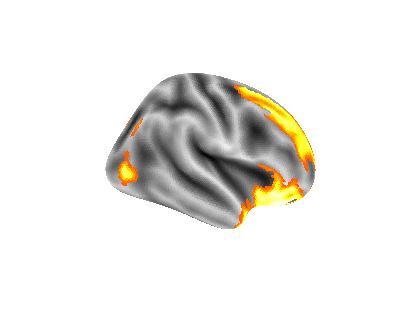

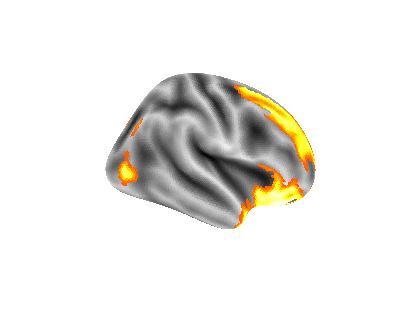

In [106]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right, cmap='hot', threshold=.01)

/usr/local/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:241: RuntimeWarning: invalid value encountered in greater_equal
  kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]


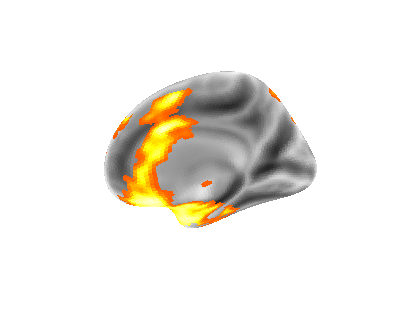

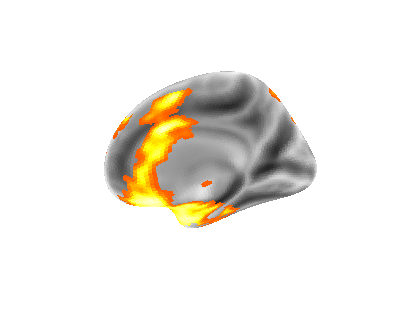

In [107]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right,
                             view='medial', cmap='hot', threshold=.01)

/usr/local/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:241: RuntimeWarning: invalid value encountered in greater_equal
  kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]


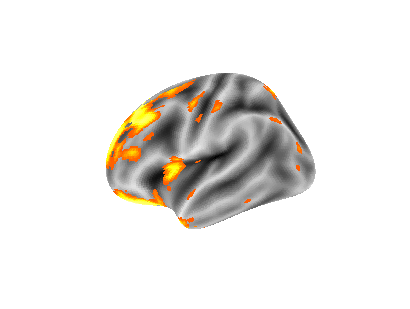

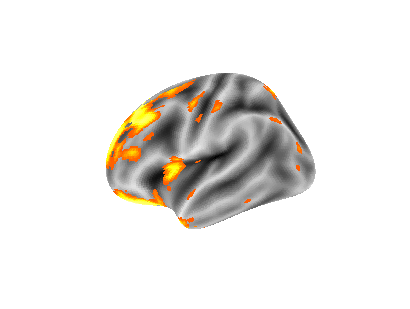

In [108]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_pl, hemi='left',
                             bg_map=fsaverage.sulc_left, cmap='hot', threshold=.01)

/usr/local/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:241: RuntimeWarning: invalid value encountered in greater_equal
  kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]


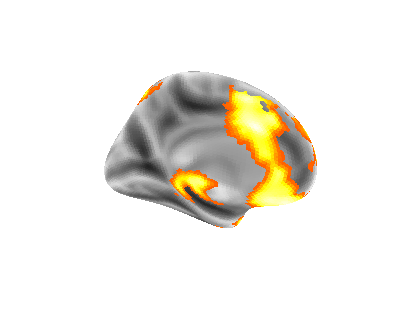

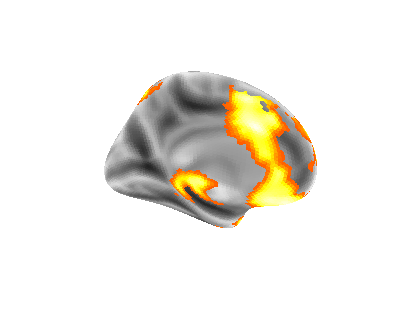

In [109]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_pl, hemi='left',
                            bg_map=fsaverage.sulc_left, view='medial', cmap='hot', threshold=.01)